In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# 1. Machine Learning for Diagnosis of 'Senioritis'

## Problem 1.1

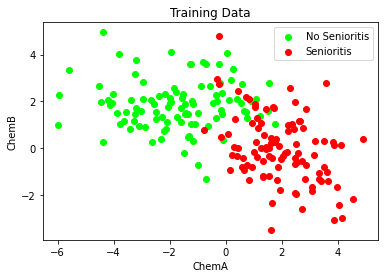

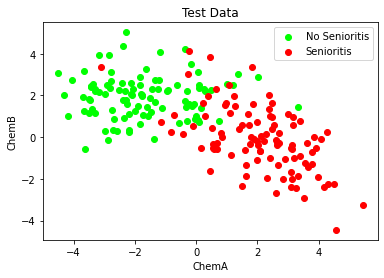

In [2]:
training = pd.read_csv("SenioritisTrainingData.csv")
fig, ax = plt.subplots()
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data")
ax.legend()
plt.show()

test = pd.read_csv("SenioritisTestData.csv")
fig, ax = plt.subplots()
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = test.loc[test["ClassLabel"] == diagnosis]["ChemA"]
    y = test.loc[test["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Test Data")
ax.legend()
plt.show()

## Problem 1.2

### (a)

In [3]:
means = pd.DataFrame()
for c, r in training.groupby("ClassLabel"):
    means[c] = r.mean()

lda_cov_matrix = np.zeros((2, 2))
for c, r in training.groupby("ClassLabel"):
    r = r.drop(["ClassLabel"], axis = 1)
    s = np.zeros((2, 2))
    for i, r2 in r.iterrows():
        x = r2.values.reshape(2, 1)
        m = means[c].values.reshape(2,1)
        s += (x - m).dot((x-m).transpose())
        lda_cov_matrix += s
        
prior = [len(training.loc[training["ClassLabel"] == "No Senioritis"])/training.shape[0], len(training.loc[training["ClassLabel"] == "Senioritis"])/training.shape[0]]
x1= np.linspace(training["ChemA"].min(), training["ChemA"].max(), 100)
lda_boundaryConstant = np.log(prior[0]/prior[1]) - 0.5*np.matmul((means["Senioritis"] + means["No Senioritis"]).transpose(), np.matmul(np.linalg.inv(lda_cov_matrix), means["Senioritis"] - means["No Senioritis"]))
lda_boundaryCoeffs = np.matmul(np.linalg.inv(lda_cov_matrix), means["Senioritis"] - means["No Senioritis"])
lda_x2 = -(lda_boundaryCoeffs[0]*x1 + lda_boundaryConstant)/lda_boundaryCoeffs[1]

### (b)

In [4]:
qda_cov_matrix_list = list()
for c, r in training.groupby("ClassLabel"):
    r = r.drop(["ClassLabel"], axis=1)
    qda_cov_matrix = np.zeros((2,2))
    for i, r2 in r.iterrows():
        x = r2.values.reshape(2, 1)
        m = means[c].values.reshape(2, 1)
        qda_cov_matrix += (x - m).dot((x - m).transpose())
    qda_cov_matrix_list.append(qda_cov_matrix / 100) 

def get_QDA_score(i, arr):
    if i == 0:
        diagnosis = "No Senioritis"
    else:
        diagnosis = "Senioritis"
    return (np.log(prior[i]) - .5 * np.log(np.linalg.det(np.linalg.inv(qda_cov_matrix_list[i])))) - .5 * (arr - means[diagnosis]).transpose() @ np.linalg.inv(qda_cov_matrix_list[i]) @ (arr - means[diagnosis])

### (c)

In [5]:
## We already derived the means and prior probabilities of the classes in the training dataset
gnb_var_matrix = np.zeros((2,2))
for i in range(gnb_var_matrix.shape[0]): #class
    if i == 0:
        diagnosis = "No Senioritis"
    else:
        diagnosis = "Senioritis"
    for j in range(gnb_var_matrix.shape[1]): #feature
        if j == 0:
            feature = "ChemA"
        else:
            feature = "ChemB"
        gnb_var_matrix[i][j] = np.var(training.loc[training["ClassLabel"] == diagnosis][feature])
        
def get_GNB_score(i, arr):
    if i == 0:
        diagnosis = "No Senioritis"
    else:
        diagnosis = "Senioritis"
    p = 1
    for feature in range(0, np.shape(test)[1]-1):
        p *= (1/np.sqrt(2*np.pi*gnb_var_matrix[i][feature])) * np.exp(-0.5*np.power((arr[feature] - means[diagnosis][feature]), 2)/gnb_var_matrix[i][feature])
    return p



### (d)

In [6]:
def distance(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i])**2
    return distance

def get_KNN_score(k, arr):
    distances = list()
    for index, r in training.iterrows():
        distances.append((r, distance(np.asarray(r[["ChemA", "ChemB"]]), arr)))
    #distances.sort(key=lambda tup: tup[1])
    distances = selectionSort(k, distances)
    decision = 0
    for element in distances[0:k]:
        if element[0]["ClassLabel"] == "No Senioritis":
            decision -= 1
        else:
            decision += 1
    if decision <= 0:
        return 0
    else:
        return 1

def selectionSort(k, tupList):
    newList = list()
    for i in range(0, k):
        min_idx = i
        for j in range(i+1, len(tupList)):
            if tupList[min_idx][1] > tupList[j][1]:
                min_idx = j
        tupList[i], tupList[min_idx] = tupList[min_idx], tupList[i]
    return tupList

## Problem 1.3

### (a)

In [7]:
n = np.shape(test)[0]
##lda
lda_y_hat = list()
for index, row in test.iterrows():
    if -(lda_boundaryCoeffs[0]*row[1] + lda_boundaryConstant)/lda_boundaryCoeffs[1] - row[2] >= 0:
        lda_y_hat.append("Senioritis")
    else:
        lda_y_hat.append("No Senioritis")
lda_tp = 0 
lda_fp = 0
lda_tn = 0
lda_fn = 0
for i in range(len(lda_y_hat)):
    if lda_y_hat[i] == test["ClassLabel"][i]:
        if lda_y_hat[i] == "Senioritis":
            lda_tp += 1
        else:
            lda_tn += 1
    else:
        if lda_y_hat[i] == "Senioritis":
            lda_fp += 1
        else:
            lda_fn += 1
print(f'!!LDA!! Probability of Error: {(lda_fn + lda_fp) / n:.3f}')

##qda
qda_y_hat = list()
for index, row in test.iterrows():
    qda_scorelist = list()
    for i in range(2):
        qda_scorelist.append(get_QDA_score(i, np.asarray(row[["ChemA", "ChemB"]]))) 
    if np.argmax(qda_scorelist) == 0:
        qda_y_hat.append("No Senioritis")
    else:
        qda_y_hat.append("Senioritis")
qda_tp = 0
qda_fp = 0
qda_tn = 0
qda_fn = 0
for i in range(len(qda_y_hat)):
    if qda_y_hat[i] == test["ClassLabel"][i]:
        if qda_y_hat[i] == "Senioritis":
            qda_tp += 1
        else:
            qda_tn += 1
    else:
        if qda_y_hat[i] == "Senioritis":
            qda_fp += 1
        else:
            qda_fn += 1
print(f'!!QDA!! Probability of Error: {(qda_fn + qda_fp) / n:.3f}')

##gnb
gnb_y_hat = list()
for index, row in test.iterrows():
    gnb_scorelist = list()
    for i in range(2):
        gnb_scorelist.append(get_GNB_score(i, np.asarray(row[["ChemA", "ChemB"]]))) 
    if np.argmax(gnb_scorelist) == 0:
        gnb_y_hat.append("No Senioritis")
    else:
        gnb_y_hat.append("Senioritis")
gnb_tp = 0
gnb_fp = 0
gnb_tn = 0
gnb_fn = 0
for i in range(len(gnb_y_hat)):
    if gnb_y_hat[i] == test["ClassLabel"][i]:
        if gnb_y_hat[i] == "Senioritis":
            gnb_tp += 1
        else:
            gnb_tn += 1
    else:
        if gnb_y_hat[i] == "Senioritis":
            gnb_fp += 1
        else:
            gnb_fn += 1
print(f'!!GNB!! Probability of Error: {(gnb_fn + gnb_fp) / n:.3f}')

##knn
knn_y_hat = list()
for index, row in test.iterrows():
    if get_KNN_score(3, np.asarray(row[["ChemA", "ChemB"]])) == 0:
        knn_y_hat.append("No Senioritis")
    else:
        knn_y_hat.append("Senioritis")
knn_tp = 0 
knn_fp = 0
knn_tn = 0
knn_fn = 0
for i in range(len(knn_y_hat)):
    if knn_y_hat[i] == test["ClassLabel"][i]:
        if knn_y_hat[i] == "Senioritis":
            knn_tp += 1
        else:
            knn_tn += 1
    else:
        if knn_y_hat[i] == "Senioritis":
            knn_fp += 1
        else:
            knn_fn += 1
print(f'!!KNN!! Probability of Error: {(knn_fn + knn_fp) / n:.3f}')

!!LDA!! Probability of Error: 0.090
!!QDA!! Probability of Error: 0.090
!!GNB!! Probability of Error: 0.085
!!KNN!! Probability of Error: 0.095


### (b)

In [8]:
print(f'!!LDA!! TPs: {lda_tp:d}, TPR: {lda_tp / n:.3f}')
print(f'!!QDA!! TPs: {qda_tp:d}, TPR: {qda_tp / n:.3f}')
print(f'!!GNB!! TPs: {gnb_tp:d}, TPR: {gnb_tp / n:.3f}')
print(f'!!KNN!! TPs: {knn_tp:d}, TPR: {knn_tp / n:.3f}')

!!LDA!! TPs: 89, TPR: 0.445
!!QDA!! TPs: 85, TPR: 0.425
!!GNB!! TPs: 86, TPR: 0.430
!!KNN!! TPs: 91, TPR: 0.455


### (c)

In [9]:
print(f'!!LDA!! FPs: {lda_fp:d}, FPR: {lda_fp / n:.3f}')
print(f'!!QDA!! FPs: {qda_fp:d}, FPR: {qda_fp / n:.3f}')
print(f'!!GNB!! FPs: {gnb_fp:d}, FPR: {gnb_fp / n:.3f}')
print(f'!!KNN!! FPs: {knn_fp:d}, FPR: {knn_fp / n:.3f}')

!!LDA!! FPs: 7, FPR: 0.035
!!QDA!! FPs: 3, FPR: 0.015
!!GNB!! FPs: 3, FPR: 0.015
!!KNN!! FPs: 10, FPR: 0.050


### (d)

In [10]:
print("!!LDA!!", "TNs:", lda_tn, "TNR:", lda_tn / n)
print("!!QDA!!", "TNs:", qda_tn, "TNR:", qda_tn / n)
print("!!GNB!!", "TNs:", gnb_tn, "TNR:", gnb_tn / n)
print("!!KNN!!", "TNs:", knn_tn, "TNR:", knn_tn / n)

!!LDA!! TNs: 93 TNR: 0.465
!!QDA!! TNs: 97 TNR: 0.485
!!GNB!! TNs: 97 TNR: 0.485
!!KNN!! TNs: 90 TNR: 0.45


### (e)

In [11]:
print("!!LDA!!", "FNs:", lda_fn, "FNR:", lda_fn / n)
print("!!QDA!!", "FNs:", qda_fn, "FNR:", qda_fn / n)
print("!!GNB!!", "FNs:", gnb_fn, "FNR:", gnb_fn / n)
print("!!KNN!!", "FNs:", knn_fn, "FNR:", knn_fn / n)

!!LDA!! FNs: 11 FNR: 0.055
!!QDA!! FNs: 15 FNR: 0.075
!!GNB!! FNs: 14 FNR: 0.07
!!KNN!! FNs: 9 FNR: 0.045


## Problem 1.4

I would most likely recommend the KNN classifier as it has the highest TPR of any of the classification algorithms for this test data. Accurately detecting senioritis is probably the most important thing in this classification problem.

## Problem 1.5

### (a)

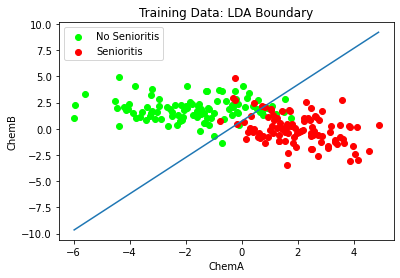

In [12]:
fig, ax = plt.subplots()
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data: LDA Boundary")
ax.legend()
plt.plot(x1, lda_x2)
plt.show()

### (b)

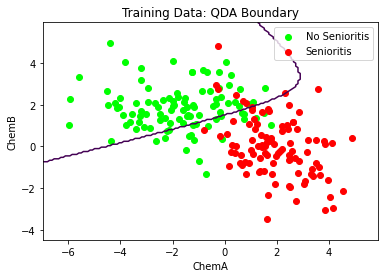

In [13]:
#TODO: Increase resolution of linspace
x_min, x_max = training["ChemA"].min() - 1, training["ChemA"].max() + 1
y_min, y_max = training["ChemB"].min() - 1, training["ChemB"].max() + 1
xx, yy = np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150)
result = np.ndarray((len(xx), len(yy)))
for X in range(len(xx)):
    for Y in range(len(yy)):
        scorelist = list()
        for i in range(2):
            scorelist.append(get_QDA_score(i, [xx[X], yy[Y]]))
        result[X, Y] = np.argmax(scorelist)
xxx, yyy = np.meshgrid(xx, yy)
fig,ax=plt.subplots(1,1)
cp = ax.contour(xxx, yyy, result, levels=[0.5])
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data: QDA Boundary")
ax.legend()
plt.show()

### (c)

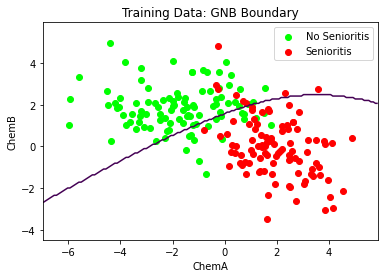

In [14]:
result = np.ndarray((len(xx), len(yy)))
for X in range(len(xx)):
    for Y in range(len(yy)):
        scorelist = list()
        for i in range(2):
            scorelist.append(get_GNB_score(i, [xx[X], yy[Y]]))
        result[X, Y] = np.argmax(scorelist)
xxx, yyy = np.meshgrid(xx, yy)
fig,ax=plt.subplots(1,1)
cp = ax.contour(xxx, yyy, result, levels=[0.5])
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data: GNB Boundary")
ax.legend()
plt.show()

### (d)

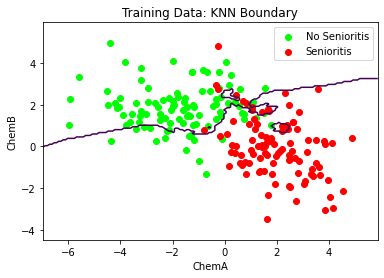

In [15]:
result = np.ndarray((len(xx), len(yy)))
for X in range(len(xx)):
    for Y in range(len(yy)):
        result[X, Y] = get_KNN_score(3, [xx[X], yy[Y]])
xxx, yyy = np.meshgrid(xx, yy)
fig,ax=plt.subplots(1,1)
cp = ax.contour(xxx, yyy, result, levels=[0.5])
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data: KNN Boundary")
ax.legend()
plt.show()

### (e)

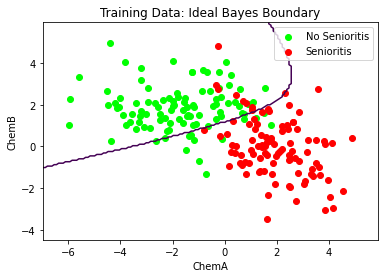

In [16]:
def get_Bayes_Score(arr, mu, cov):
    return sps.multivariate_normal.pdf(arr, mean=mu, cov=cov)

mean_list = np.array([[-2, 2], [2, 0]])
cov_list = np.array([[[3, 0], [0, 1]], [[2, -1], [-1, 2]]])

result = np.ndarray((len(xx), len(yy)))
for X in range(len(xx)):
    for Y in range(len(yy)):
        scorelist = list()
        for i in range(2):
            scorelist.append(get_Bayes_Score([xx[X], yy[Y]], mean_list[i], cov_list[i]))
        result[X, Y] = np.argmax(scorelist)
xxx, yyy = np.meshgrid(xx, yy)
fig,ax=plt.subplots(1,1)
cp = ax.contour(xxx, yyy, result, levels=[0.5])
for color in ["Lime","Red"]: 
    if color == "Lime":
        diagnosis = "No Senioritis"
    if color == "Red":
        diagnosis = "Senioritis"
    x = training.loc[training["ClassLabel"] == diagnosis]["ChemA"]
    y = training.loc[training["ClassLabel"] == diagnosis]["ChemB"]
    ax.scatter(x, y, c=color, label=diagnosis)
plt.xlabel("ChemA")
plt.ylabel("ChemB")
plt.title("Training Data: Ideal Bayes Boundary")
ax.legend()
plt.show()

## Problem 1.6


### (a)

In [17]:
testerrors = list()
for k in range(1, 11):
    knn_y_hat = list()
    for index, row in test.iterrows():
        if get_KNN_score(k, np.asarray(row[["ChemA", "ChemB"]])) == 0:
            knn_y_hat.append("No Senioritis")
        else:
            knn_y_hat.append("Senioritis") 
    error = 0
    for i in range(len(knn_y_hat)):
        if knn_y_hat[i] != test["ClassLabel"][i]:
            error += 1
    testerrors.append(error)
trainingerrors = list()
for k in range(1, 11):
    knn_y_hat = list()
    for index, row in training.iterrows():
        if get_KNN_score(k, np.asarray(row[["ChemA", "ChemB"]])) == 0:
            knn_y_hat.append("No Senioritis")
        else:
            knn_y_hat.append("Senioritis") 
    error = 0
    for i in range(len(knn_y_hat)):
        if knn_y_hat[i] != test["ClassLabel"][i]:
            error += 1
    trainingerrors.append(error)

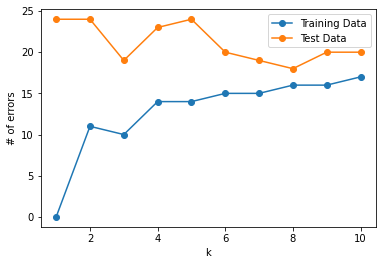

In [18]:
k = np.arange(1, 11, 1)
p1 = plt.plot(k, trainingerrors, '-o')
p2 = plt.plot(k, testerrors, '-o')
plt.xlabel("k")
plt.ylabel("# of errors")
plt.legend(('Training Data', 'Test Data'))
plt.show()

### (b)

It seems like a k=3 for the KNN classifier combines a relatively low number of errors for both the test and training data, so I would recommend it go into production for diagnostics of senioritis